### Introduction
<p>As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

    
</p>

<p>
    
Data Description:

The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

Attributes:
id : unique identifier for candidate (numeric)

job_title : job title for candidate (text)

location : geographical location for candidate (text)

connections: number of connections candidate has, 500+ means over 500 (text)

Output (desired target):
fit - how fit the candidate is for the role? (numeric, probability between 0-1)
</p>

In [74]:
# Import all the rquired libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [75]:
# Import the dataset
df=pd.read_csv("potential-talents.csv")

In [76]:
df.head(10)

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN
6,7,Student at Humber College and Aspiring Human R...,Kanada,61,NaN
7,8,HR Senior Specialist,San Francisco Bay Area,500+,NaN
8,9,Student at Humber College and Aspiring Human R...,Kanada,61,NaN
9,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,NaN


In [77]:
# Group the data to see the occurances of the job title
df1=df['id'].groupby(df["job_title"]).count()
df1=df1.reset_index()
df2=pd.DataFrame(df1)
df2.columns=["job_title","count"]

In [78]:
df2.sort_values(by=["count"],ascending=False)

,job_title,count
0,2019 C.T. Bauer College of Business Graduate (...,7
48,Student at Humber College and Aspiring Human R...,7
7,Aspiring Human Resources Professional,7
36,People Development Coordinator at Ryan,6
34,Native English Teacher at EPIK (English Progra...,5
19,HR Senior Specialist,5
10,Aspiring Human Resources Specialist,5
41,Seeking Human Resources HRIS and Generalist Po...,4
2,Advisory Board Member at Celal Bayar University,4
20,Human Resources Coordinator at InterContinenta...,4


#### Text Pre Processing

<p>Create functions for various text processing actions to clean the dataframe </p>

##### Remove Stopwords

In [157]:
def remove_stopword(text):
    """
    Text preprocessing tasks
    - Remove Stopwords
    """
    sw_nltk = stopwords.words('english')
    sw_nltk.extend(["in","the","at","a","an","of","and","is"])
#     stopwords=["in","the","at","a","an","of","and","is"]
    words=text.split(" ")
    used_words=[]
    for w in words:
        if w not in sw_nltk:
            used_words.append(w)
            ret_string=" ".join(used_words)
    return ret_string

##### Remove Special characters

In [155]:
def remove_special(text):
    """
    Remove special characters '|)(-:,'
    """
    text=text.replace("|","")
    text=text.replace("(","")
    text=text.replace(")","")
    text=text.replace("-"," ")
    sp_chars=[',',':','.','!']
    ret_words=[]
    for i in text:
        if i not in sp_chars:
            ret_words.append(i)
            text="".join(ret_words)

    return text

#### Lemmatization

In [81]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
def text_lemm(text):
    """
    Tokenize the text and then apply lemmatize. Join again to form the string
    """
    lemmatizer=WordNetLemmatizer()
    text_token=word_tokenize(text)
    lemma_words=' '.join([lemmatizer.lemmatize(word) for word in text_token])
    return lemma_words

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [151]:
def text2token(text):
    """
    Tokenize the string and join again to form the string
    """
    tokens=word_tokenize(text)
    return ' '.join(tokens)

# df['clean_title']=df['clean_title'].apply(text2token)

In [152]:
# Function for text pre-processing
def text_preprocess(df,col,newcol):
    stopwords=["in","the","at","a","an","of","and","is"]
    df[newcol]= df[col].apply(remove_stopword)
    df[newcol]= df[newcol].apply(remove_special)
    df[newcol]=df[newcol].apply(text_lemm)
#     df[newcol]=df[newcol].apply(text2token)
    df[newcol]=df[newcol].map(lambda x: x.lower())
    return df

##### Apply the preprocessing function

In [158]:
df_clean = text_preprocess(df,'job_title','clean_title')

In [164]:
# View the cleaned data
df_clean.head()

,id,job_title,location,connection,fit,clean_title
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,2019 ct bauer college business graduate magna ...
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,native english teacher epik english program korea
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspiring human resources professional
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member celal bayar university


In [96]:
df['clean_title']

0      2019 ct bauer college business graduate magna ...
1      native english teacher epik english program korea
2                  aspiring human resources professional
3                    people development coordinator ryan
4           advisory board member celal bayar university
                             ...                        
99     aspiring human resources manager graduating ma...
100                   human resources generalist loparex
101            business intelligence analytics travelers
102                       always set them up for success
103        director of administration excellence logging
Name: clean_title, Length: 104, dtype: object

#### Vectorization
<p> Convert the words into a vector form </p>

In [98]:
from sklearn.feature_extraction.text import CountVectorizer


In [117]:
def text_vectorize(df,col):
    cv=CountVectorizer(max_df=.8,max_features=70)
    count_vector=cv.fit_transform(df[col])
    features=cv.get_feature_names_out()
    count_df=pd.DataFrame(data=count_vector.toarray(),columns=cv.get_feature_names_out())
    return count_df , features
    

In [118]:
vect_df,features=text_vectorize(df,'clean_title')


In [119]:
vect_df

,2019,advisory,america,aspiring,atlanta,bauer,bayar,board,buckhead,business,...,sphr,staffing,student,svp,systems,teacher,the,to,university,woodlands
0,1,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Word Count
<p> Word count display of the top words </p>

In [122]:
def count_word(df_input):
    count_dict={}
    for col in df_input.columns:
        c=df_input[col].sum()
        if c>=7:
            count_dict[col]=c
    return count_dict
        
dict_display=count_word(vect_df)
dict_display.values()

dict_values([7, 35, 7, 11, 14, 10, 7, 7, 10, 14, 7, 63, 7, 7, 7, 7, 20, 63, 15, 12, 16, 12])

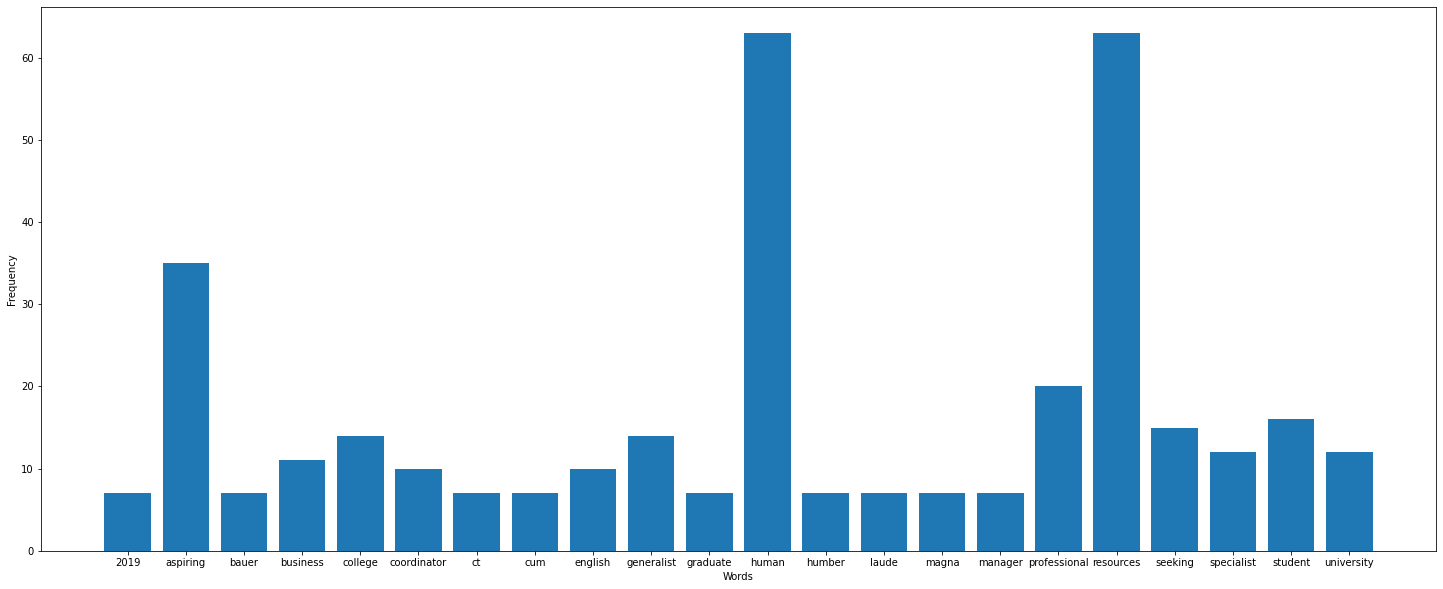

In [123]:
plt.figure(figsize=(25,10))
plt.bar(x=dict_display.keys(),height=dict_display.values())
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

### Tf - Idf

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(use_idf=True)
tfidf_vector=tfidf.fit_transform(df['clean_title'])

In [121]:
# Display one of the rows with weights
first_vector=tfidf_vector[8]
first_df=pd.DataFrame(data=first_vector.toarray().reshape(-1,1),index=tfidf.get_feature_names_out(),columns=["tfidf"])
first_df.sort_values(by='tfidf',ascending=False)

,tfidf
humber,0.521177
generalist,0.429524
college,0.429524
student,0.411275
aspiring,0.301877
...,...
from,0.000000
gis,0.000000
gphr,0.000000
graduate,0.000000


#### Cosine Similarity

In [124]:
from sklearn.metrics.pairwise import cosine_similarity 
cosine_result=cosine_similarity(tfidf_vector)

In [127]:
cosine_result

array([[1.        , 0.        , 0.35660223, ..., 0.09851004, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.35660223, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.09851004, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [130]:
# Function to flatten the array of lists of Cosine Similarity
def cos_shape(cos):
    cos_m=[]
    iden=cos.shape[0]
    cos=cos-np.identity(iden)
    for x in cos:
        xx=max(x)
        cos_m.append(xx)
    return cos_m
 
cosine_final=cos_shape(cosine_result)
cosine_final=np.reshape(cosine_final,(iden,1))


array([[1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],


In [134]:
# Create a dataframe for the scores
cosine_df=pd.DataFrame(cosine_final,columns=["similarity_score"])

# Concatanate the score dataframe to the main dataframe
df_score=pd.concat([df,cosine_df],axis=1)

In [161]:
df_score.to_excel("scored_data.xlsx")

##### Download the final dataframe with scores into an excel file 

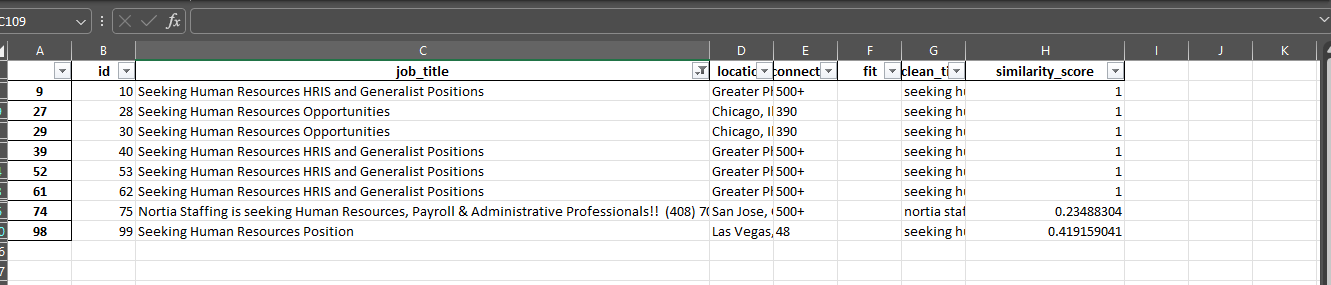